# 贝叶斯网

In [1]:
import pandas as pd
df = pd.read_csv('data/train.csv')
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [110]:
from sklearn.model_selection import train_test_split

X = df[['Pclass','Sex','Age','Fare','Cabin','Survived']]
y = df['Survived']

def trans_age(x):
    if x <= 15:
        return 0
    if x <= 55:
        return 1
    return 2

def trans_sex(x):
    return 0 if x == 'male' else 1

def trans_fare(x):
    if x < 8:
        return 0
    if x < 31:
        return 1
    return 2

X.Age = X.Age.fillna(X.Age.median())
X.Age = X.Age.apply(trans_age)
X.Sex = X.Sex.apply(trans_sex)
X.loc[X.Cabin.notnull(),'Cabin'] = 1
X.loc[X.Cabin.isnull(),'Cabin'] = 0
X.Fare = X.Fare.fillna(X.Fare.median())
X.Fare = X.Fare.apply(trans_fare)

X_train, X_valid, y_train, y_valid = train_test_split(X,y,
                                                      test_size=0.25,
                                                      random_state=33)

## 设计网络结构

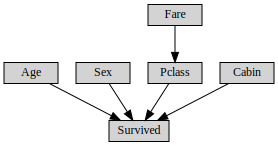

In [111]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator

model = BayesianModel([('Age', 'Survived'), 
                       ('Sex', 'Survived'),
                       ('Fare','Pclass'),
                       ('Pclass','Survived'),
                       ('Cabin','Survived')])

def showBN(model, save=False):
    '''传入BayesianModel对象，调用graphviz绘制结构图，jupyter中可直接显示'''
    from graphviz import Digraph
    node_attr = dict(
     style='filled',
     shape='box',
     align='left',
     fontsize='12',
     ranksep='0.1',
     height='0.2'
    )
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    edges=model.edges()
    for a,b in edges:
        dot.edge(a,b)
    if save:
        dot.view(cleanup=True)
    return dot
showBN(model)  

## 确定网络参数

In [112]:
model.fit(X_train, estimator=BayesianEstimator, prior_type="BDeu")

In [53]:
print('Nodes:\n', model.nodes())
print('Edges:\n', model.edges())
print()

print('CPD of Age:\n', model.get_cpds('Age'))
print('CPD of Pclass:\n', model.get_cpds('Pclass'))

Nodes:
 ['Age', 'Survived', 'Sex', 'Fare', 'Pclass', 'Cabin']
Edges:
 [('Age', 'Survived'), ('Sex', 'Survived'), ('Fare', 'Pclass'), ('Pclass', 'Survived'), ('Cabin', 'Survived')]

CPD of Age:
 +--------+-----------+
| Age(0) | 0.085686  |
+--------+-----------+
| Age(1) | 0.871719  |
+--------+-----------+
| Age(2) | 0.0425953 |
+--------+-----------+
CPD of Pclass:
 +-----------+----------------------+---------------------+---------------------+
| Fare      | Fare(0)              | Fare(1)             | Fare(2)             |
+-----------+----------------------+---------------------+---------------------+
| Pclass(1) | 0.019047619047619046 | 0.12453087683384512 | 0.7192254495159058  |
+-----------+----------------------+---------------------+---------------------+
| Pclass(2) | 0.029761904761904764 | 0.37632207437734566 | 0.11549100968188104 |
+-----------+----------------------+---------------------+---------------------+
| Pclass(3) | 0.9511904761904761   | 0.4991470487888093  | 0.1

## 进行推断

In [113]:
from pgmpy.inference import VariableElimination

model_infer = VariableElimination(model)

q = model_infer.query(variables=['Survived'])
print(q)

Eliminating: Fare: 100%|██████████| 5/5 [00:00<00:00, 94.80it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.6249 |
+-------------+-----------------+
| Survived(1) |          0.3751 |
+-------------+-----------------+


In [121]:
q = model_infer.query(variables=['Survived'], evidence={'Fare': 2, 'Sex': 1})
print(q)

Eliminating: Cabin: 100%|██████████| 3/3 [00:00<00:00, 136.54it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.1347 |
+-------------+-----------------+
| Survived(1) |          0.8653 |
+-------------+-----------------+
